In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
import glob
import torchvision.io
import cv2
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
class LipReadingDataset(Dataset):
    def __init__(self, root_dir, phase='train', transform=None, fixed_frame_count=29, max_classes=500):
        self.root_dir = root_dir
        self.phase = phase
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))[:max_classes]
        self.files = []
        self.fixed_frame_count = fixed_frame_count
        
        for cls in self.classes:
            class_dir = os.path.join(root_dir, cls, phase)
            for file in os.listdir(class_dir):
                if file.endswith('.mp4'):
                    self.files.append((os.path.join(class_dir, file), cls))
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        video_path, label = self.files[idx]
        frames = self.load_video(video_path)
        
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        
        label = self.classes.index(label)
        frames = torch.stack(frames)
        
        return frames, label
    
    def load_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        return frames

In [3]:
# Function to split the dataset
def split_dataset(dataset, train_ratio=0.8):
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size
    return random_split(dataset, [train_size, val_size])

# Function to evaluate the model
def evaluate_model(model, data_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for videos, labels in data_loader:
            videos = videos.to(device)
            labels = labels.to(device)
            outputs = model(videos)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

def plot_metrics(train_losses, val_accuracies, train_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [4]:
# Define the model architecture using VGG
class LipReadingModel(nn.Module):
    def __init__(self, num_classes=500):
        super(LipReadingModel, self).__init__()
        # VGG16 as feature extractor
        self.vgg = torchvision.models.vgg16(weights='DEFAULT')

        self.vgg.classifier = nn.Identity()  # Remove final classification layer
        
        self.bn1 = nn.BatchNorm2d(512)
        
        # RNN for sequence modeling
        self.rnn = nn.LSTM(input_size=512*2*2, hidden_size=256, num_layers=2, batch_first=True, bidirectional=True, dropout=0.5)

        # Fully connected layer for classification
        self.fc = nn.Linear(256*2, num_classes)  # bidirectional doubles the output features

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.vgg.features(c_in)
        
        c_out = self.bn1(c_out)  # Apply batch normalization
        c_out = torch.nn.functional.relu(c_out)  # Example activation function
        
        c_out = c_out.view(batch_size, timesteps, -1)  # Flatten for LSTM
        r_out, _ = self.rnn(c_out)

        out = self.fc(r_out[:, -1, :])
        return out

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 160MB/s]


Epoch 1/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [1/40], Avg Loss: 3.2183, Train Accuracy: 0.0428, Validation Accuracy: 0.0491


Epoch 2/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [2/40], Avg Loss: 3.2017, Train Accuracy: 0.0539, Validation Accuracy: 0.0553


Epoch 3/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [3/40], Avg Loss: 3.1861, Train Accuracy: 0.0590, Validation Accuracy: 0.0621


Epoch 4/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [4/40], Avg Loss: 3.1062, Train Accuracy: 0.0863, Validation Accuracy: 0.1251


Epoch 5/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [5/40], Avg Loss: 2.6516, Train Accuracy: 0.1860, Validation Accuracy: 0.2223


Epoch 6/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [6/40], Avg Loss: 2.2956, Train Accuracy: 0.2841, Validation Accuracy: 0.2995


Epoch 7/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [7/40], Avg Loss: 2.0270, Train Accuracy: 0.3666, Validation Accuracy: 0.3934


Epoch 8/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [8/40], Avg Loss: 1.8239, Train Accuracy: 0.4312, Validation Accuracy: 0.4330


Epoch 9/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [9/40], Avg Loss: 1.6885, Train Accuracy: 0.4805, Validation Accuracy: 0.4462


Epoch 10/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [10/40], Avg Loss: 1.6152, Train Accuracy: 0.5027, Validation Accuracy: 0.4590
Best model saved to /kaggle/working/best_vgg16_lstm_25Class_model_epoch10.pth with learning rate: 0.0001 and batch size: 32


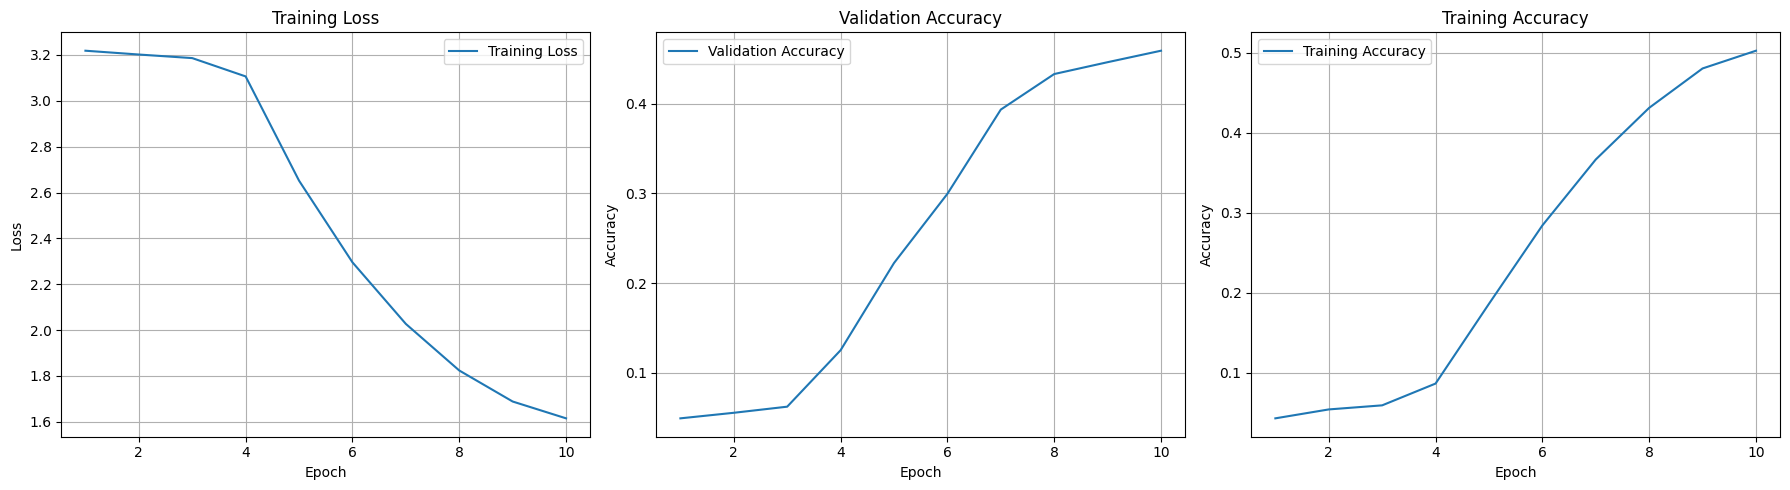

Epoch 11/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [11/40], Avg Loss: 1.6010, Train Accuracy: 0.5090, Validation Accuracy: 0.4566


Epoch 12/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [12/40], Avg Loss: 1.5908, Train Accuracy: 0.5141, Validation Accuracy: 0.4611


Epoch 13/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [13/40], Avg Loss: 1.5725, Train Accuracy: 0.5161, Validation Accuracy: 0.4753


Epoch 14/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [14/40], Avg Loss: 1.5153, Train Accuracy: 0.5309, Validation Accuracy: 0.4896


Epoch 15/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [15/40], Avg Loss: 1.4264, Train Accuracy: 0.5573, Validation Accuracy: 0.5360


Epoch 16/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [16/40], Avg Loss: 1.2987, Train Accuracy: 0.5967, Validation Accuracy: 0.5600


Epoch 17/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [17/40], Avg Loss: 1.1711, Train Accuracy: 0.6355, Validation Accuracy: 0.5542


Epoch 18/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [18/40], Avg Loss: 1.0577, Train Accuracy: 0.6687, Validation Accuracy: 0.6050


Epoch 19/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [19/40], Avg Loss: 0.9323, Train Accuracy: 0.7064, Validation Accuracy: 0.6002


Epoch 20/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [20/40], Avg Loss: 0.8165, Train Accuracy: 0.7444, Validation Accuracy: 0.6594
Best model saved to /kaggle/working/best_vgg16_lstm_25Class_model_epoch20.pth with learning rate: 0.0001 and batch size: 32


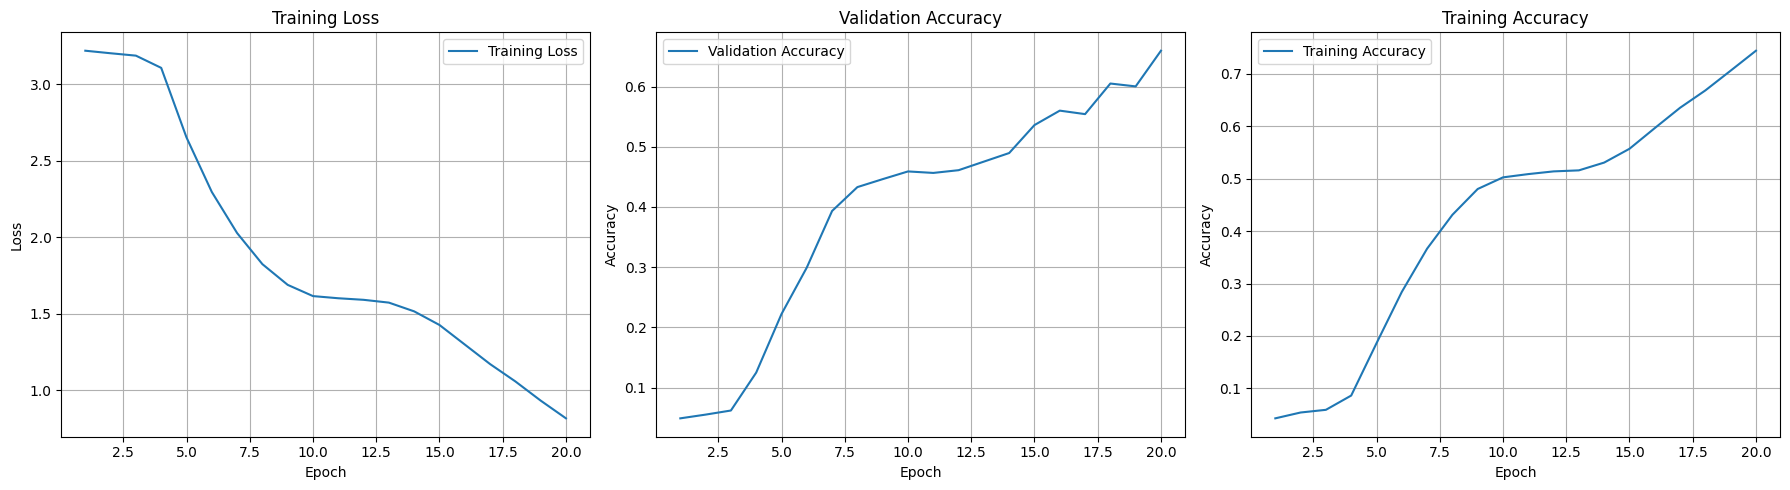

Epoch 21/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [21/40], Avg Loss: 0.6936, Train Accuracy: 0.7831, Validation Accuracy: 0.6836


Epoch 22/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [22/40], Avg Loss: 0.5740, Train Accuracy: 0.8192, Validation Accuracy: 0.6830


Epoch 23/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [23/40], Avg Loss: 0.4583, Train Accuracy: 0.8582, Validation Accuracy: 0.7071


Epoch 24/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [24/40], Avg Loss: 0.3563, Train Accuracy: 0.8922, Validation Accuracy: 0.7170


Epoch 25/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [25/40], Avg Loss: 0.2566, Train Accuracy: 0.9242, Validation Accuracy: 0.7395


Epoch 26/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [26/40], Avg Loss: 0.1681, Train Accuracy: 0.9522, Validation Accuracy: 0.7583


Epoch 27/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [27/40], Avg Loss: 0.1014, Train Accuracy: 0.9736, Validation Accuracy: 0.7606


Epoch 28/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [28/40], Avg Loss: 0.0542, Train Accuracy: 0.9878, Validation Accuracy: 0.7744


Epoch 29/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [29/40], Avg Loss: 0.0326, Train Accuracy: 0.9942, Validation Accuracy: 0.7825


Epoch 30/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [30/40], Avg Loss: 0.0231, Train Accuracy: 0.9965, Validation Accuracy: 0.7812
Best model saved to /kaggle/working/best_vgg16_lstm_25Class_model_epoch30.pth with learning rate: 0.0001 and batch size: 32


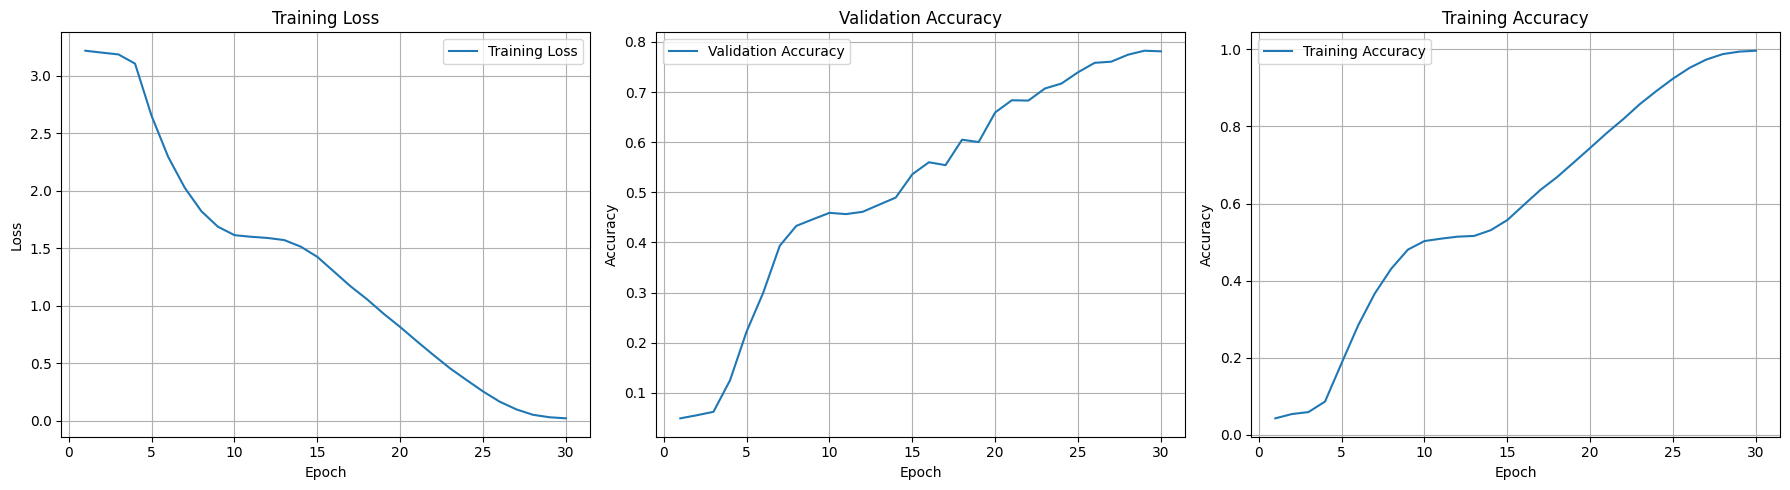

Epoch 31/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [31/40], Avg Loss: 0.0207, Train Accuracy: 0.9972, Validation Accuracy: 0.7810


Epoch 32/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [32/40], Avg Loss: 0.0197, Train Accuracy: 0.9975, Validation Accuracy: 0.7808


Epoch 33/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [33/40], Avg Loss: 0.0207, Train Accuracy: 0.9970, Validation Accuracy: 0.7713


Epoch 34/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [34/40], Avg Loss: 0.0211, Train Accuracy: 0.9960, Validation Accuracy: 0.7666


Epoch 35/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [35/40], Avg Loss: 0.0388, Train Accuracy: 0.9893, Validation Accuracy: 0.7529


Epoch 36/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [36/40], Avg Loss: 0.0649, Train Accuracy: 0.9809, Validation Accuracy: 0.7581


Epoch 37/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [37/40], Avg Loss: 0.1113, Train Accuracy: 0.9660, Validation Accuracy: 0.7344


Epoch 38/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [38/40], Avg Loss: 0.1554, Train Accuracy: 0.9514, Validation Accuracy: 0.7484


Epoch 39/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [39/40], Avg Loss: 0.1731, Train Accuracy: 0.9465, Validation Accuracy: 0.7443


Epoch 40/40:   0%|          | 0/606 [00:00<?, ?it/s]

Learning Rate: 0.0001, Batch Size: 32, Epoch [40/40], Avg Loss: 0.1799, Train Accuracy: 0.9434, Validation Accuracy: 0.7230
Best model saved to /kaggle/working/best_vgg16_lstm_25Class_model_epoch40.pth with learning rate: 0.0001 and batch size: 32


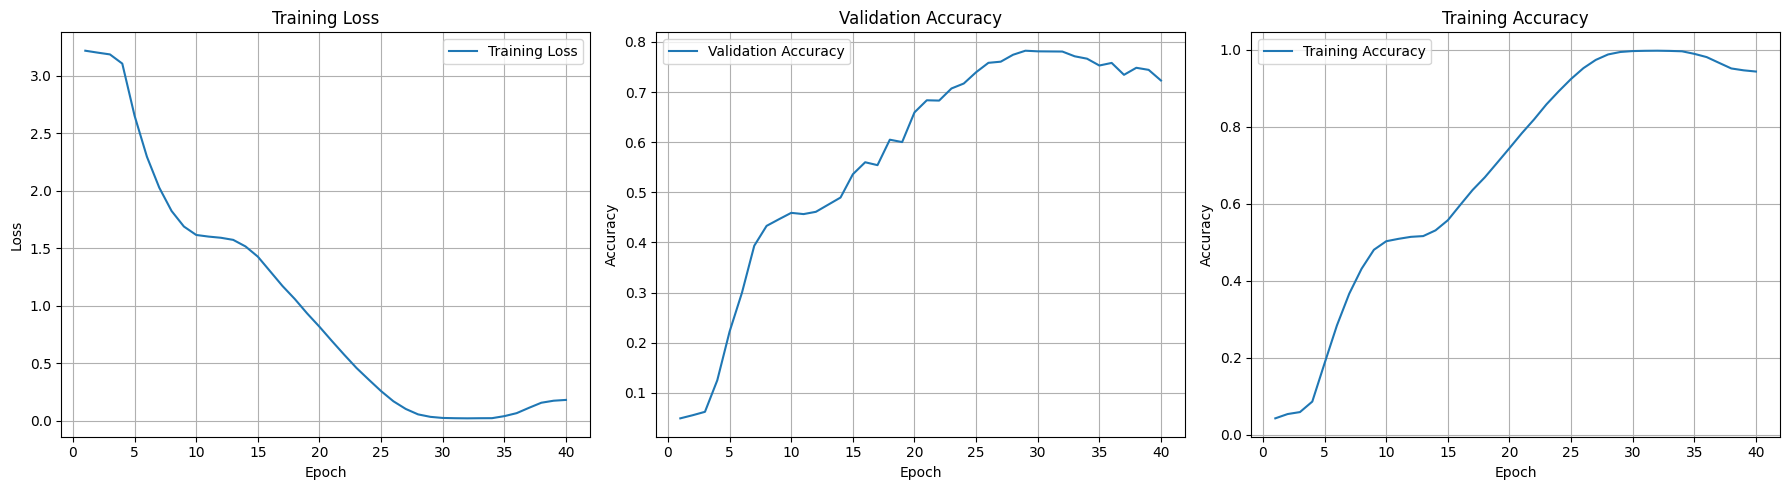

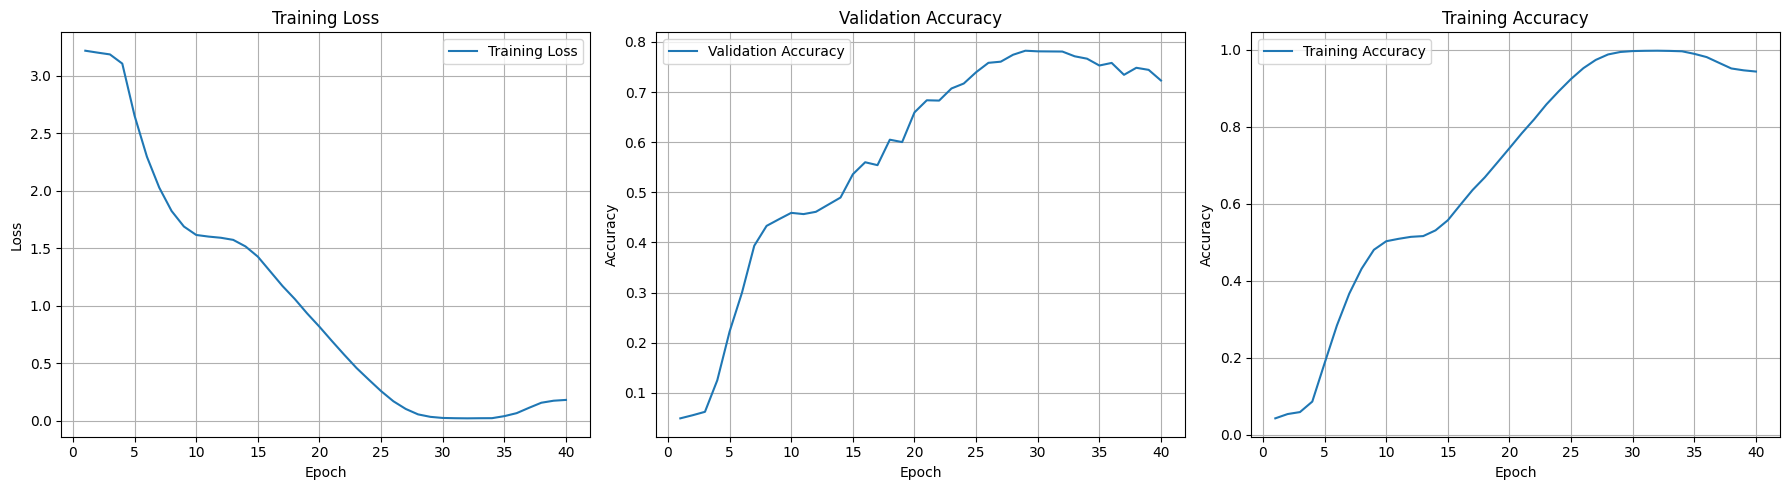

In [5]:
torch.cuda.empty_cache()
# Hyperparameters grid
num_epochs = 40
learning_rates = [0.0001]
batch_sizes = [32]
best_val_accuracy = 0
best_train_accuracy = 0
best_model = None

# Directories and device setup
root_dir = '/kaggle/input/lrw-25-words/preprocessed_25_1000'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# Dataset and DataLoader
train_val_dataset = LipReadingDataset(root_dir, 'train', transform=transform, max_classes=25)
train_dataset, val_dataset = split_dataset(train_val_dataset, train_ratio=0.8)
test_dataset = LipReadingDataset(root_dir, 'test', transform=transform, max_classes=25)

best_train_loss = []
best_val_acc = []
best_train_acc = []

# Hyperparameter tuning
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        num_classes = len(train_val_dataset.classes)
        model = LipReadingModel(num_classes=num_classes)
        model = nn.DataParallel(model, device_ids=[0, 1]) # For 2 GPUs
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

        # Collect and plot metrics
        train_losses = []
        val_accuracies = []
        train_accuracies = []

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')
            
            all_labels = []
            all_preds = []

            for videos, labels in progress_bar:
                videos = videos.to(device)
                labels = labels.to(device)
                outputs = model(videos)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                epoch_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())
                
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            avg_loss = epoch_loss / len(train_loader)
            train_accuracy = accuracy_score(all_labels, all_preds)
            val_accuracy = evaluate_model(model, val_loader, device)

            train_losses.append(avg_loss)
            val_accuracies.append(val_accuracy)
            train_accuracies.append(train_accuracy)

            print(f'Learning Rate: {learning_rate}, Batch Size: {batch_size}, Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            
            scheduler.step()  # Step the scheduler
            
            #if epoch > 5 and (val_accuracy - best_val_accuracy < -0.01):
                #print(val_accuracy - best_val_accuracy)
                #break

            # Track the best model based on validation accuracy
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_train_accuracy = train_accuracy
                best_model = model.state_dict()
                best_hyperparams = (learning_rate, batch_size)
            if (((epoch+1) % 10) == 0):
                # Save the model after every 10th epoch
                model_path = f'/kaggle/working/best_vgg16_lstm_25Class_model_epoch{epoch+1}.pth'
                torch.save(model, model_path)
                print(f"Best model saved to {model_path} with learning rate: {learning_rate} and batch size: {batch_size}")
                plot_metrics(train_losses, val_accuracies, train_accuracies)
        if val_accuracy >= best_val_accuracy:
            best_train_loss = train_losses
            best_val_acc = val_accuracies
            best_train_acc = train_accuracies
        plot_metrics(train_losses, val_accuracies, train_accuracies)

Number of parameters: 21028185
Best model saved to /kaggle/working/best_vgg16_lstm_25Class_model.pth with learning rate: 0.0001 and batch size: 32
Test Accuracy: 0.6604


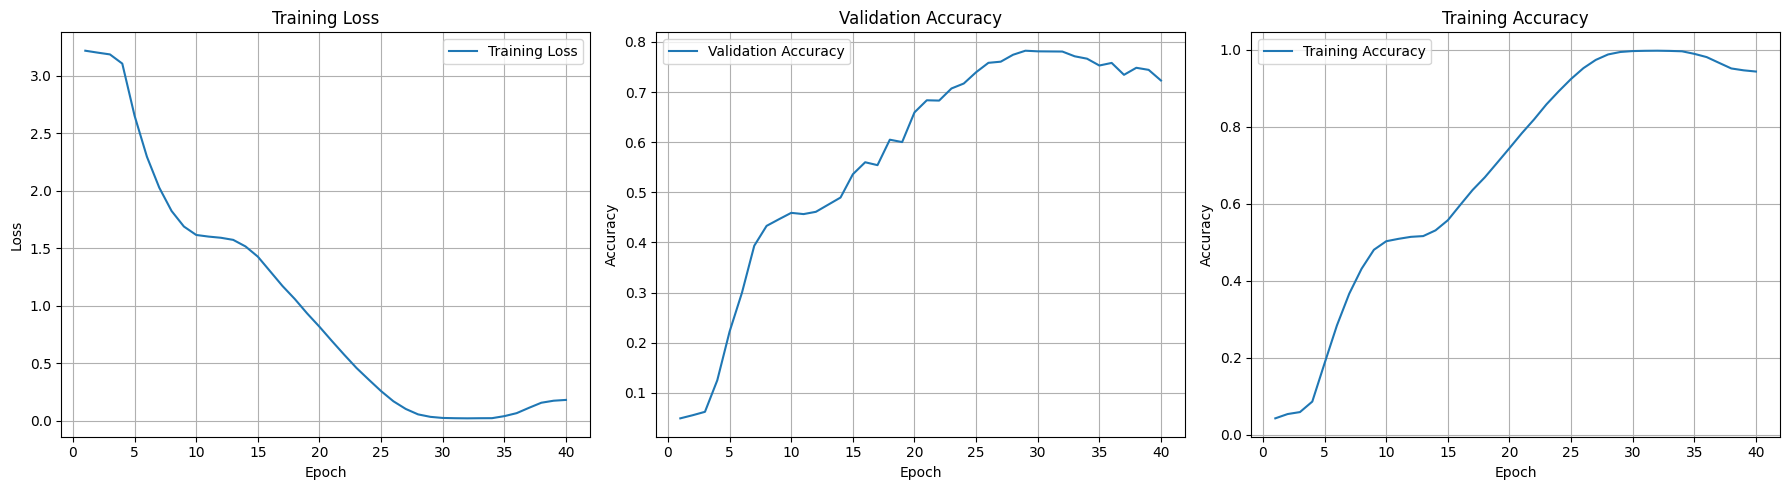

In [6]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

# Save the best model after all epochs
best_model_path = '/kaggle/working/best_vgg16_lstm_25Class_model.pth'
torch.save(best_model, best_model_path)
print(f"Best model saved to {best_model_path} with learning rate: {best_hyperparams[0]} and batch size: {best_hyperparams[1]}")

# Evaluate on test set
model.load_state_dict(best_model)
test_accuracy = evaluate_model(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot metrics for the best model
plot_metrics(train_losses, val_accuracies, train_accuracies)